In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import random
import re
import itertools
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.core.debugger import set_trace

In [3]:
# logging set-up
import logging
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    datefmt='%d/%m/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
# Make deterministic
random.seed(47)
torch.manual_seed(47);

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'

In [6]:
# Enable cuDNN autotuner. This runs a short benchmark and selects the convolution algorithm with the best performance.
torch.backends.cudnn.benchmark = True  

In [7]:
# path = Path('/data/s4314719/image-captioning/')  # set this to the path where the dataset should be stored
# path = Path('/image_data/')  # set this to the path where the dataset should be stored
# path = Path('C:/Users/leann/Documents/Master AI IS/Deep Learning/image_data/')
path = Path('/data/s4184416/image-captioning/')

path.mkdir(exist_ok=True)

In [8]:
img_dir = path/'Flicker8k_Dataset'
ann_file = path/'Flickr8k.token.txt'

In [9]:
URL = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/'
FILENAMES = ['Flickr8k_text.zip', 'Flickr8k_Dataset.zip']

In [10]:
# Download dataset
import requests
from zipfile import ZipFile

for fn in FILENAMES:
    if not (path/fn).exists():  # do not download if the dataset has already been downloaded
        print(f'Downloading {fn}')
        r = requests.get(URL + fn)
        (path/fn).write_bytes(r.content)
        print(f'Extracting files...')
        with ZipFile(path/fn) as zipf:
            zipf.extractall(path)

In [11]:
list(path.glob('*')) # list all files

[PosixPath('/data/s4184416/image-captioning/__MACOSX'),
 PosixPath('/data/s4184416/image-captioning/Flickr_8k.trainImages.txt'),
 PosixPath('/data/s4184416/image-captioning/Flickr8k_Dataset.zip'),
 PosixPath('/data/s4184416/image-captioning/Flickr8k.lemma.token.txt'),
 PosixPath('/data/s4184416/image-captioning/ExpertAnnotations.txt'),
 PosixPath('/data/s4184416/image-captioning/readme.txt'),
 PosixPath('/data/s4184416/image-captioning/Flicker8k_Dataset'),
 PosixPath('/data/s4184416/image-captioning/CrowdFlowerAnnotations.txt'),
 PosixPath('/data/s4184416/image-captioning/Flickr_8k.testImages.txt'),
 PosixPath('/data/s4184416/image-captioning/Flickr8k.token.txt'),
 PosixPath('/data/s4184416/image-captioning/Flickr8k_text.zip'),
 PosixPath('/data/s4184416/image-captioning/Flickr_8k.devImages.txt')]

In [12]:
print((path/'Flickr8k.token.txt').read_text()[:696])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .


### Preprocessing the images

In [13]:
# Calculate mean and standard deviation over all channels for normalization
# mean = torch.cat([ex[0].view(3, -1) for ex in data], 1).mean(1)
# std = torch.cat([ex[0].view(3, -1) for ex in data], 1).std(1)
# mean = np.array([0.4629, 0.4468, 0.4050])
# std = np.array([0.2661, 0.2587, 0.2727])

# normalization data for pretrained PyTorch model
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [14]:
from torchvision import transforms

# We resize the images and center crop them, as in the 'Show, attend and tell' paper. In the paper they
# resize the shortest side to 256 while preserving the aspect ratio, and then apply a center crop to 
# end up with an image of size 224x224. Note that for quick experimentation, we can use a smaller image 
# size (e.g. 128x128) to speed up training. 
trnsf = {
    'train': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(0.5),
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'eval': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

### Preprocessing the captions

In [15]:
from data.data import Lang
from src.caption_utils import preprocess_tokens

# Calls the preprocessing of the captions which may take a while (progress is printed)
# img_captions_enc, known_words, _ = preprocess_tokens(ann_file)
img_captions_enc, tokens, word2idx, idx2word = preprocess_tokens(ann_file)
lang = Lang(tokens, word2idx, idx2word)
vocab_size = len(tokens)
vocab_size

08/04/2021 00:53:52 - src.caption_utils - INFO - Creating word dictionary: 0/40461
08/04/2021 00:53:53 - src.caption_utils - INFO - Creating word dictionary: 10000/40461
08/04/2021 00:53:55 - src.caption_utils - INFO - Creating word dictionary: 20000/40461
08/04/2021 00:53:56 - src.caption_utils - INFO - Creating word dictionary: 30000/40461
08/04/2021 00:53:58 - src.caption_utils - INFO - Creating word dictionary: 40000/40461
08/04/2021 00:53:58 - src.caption_utils - INFO - Replacing tokens with numerical values: 0/40461
08/04/2021 00:54:00 - src.caption_utils - INFO - Replacing tokens with numerical values: 10000/40461
08/04/2021 00:54:01 - src.caption_utils - INFO - Replacing tokens with numerical values: 20000/40461
08/04/2021 00:54:02 - src.caption_utils - INFO - Replacing tokens with numerical values: 30000/40461
08/04/2021 00:54:04 - src.caption_utils - INFO - Replacing tokens with numerical values: 40000/40461


5223

### Split data up into train and evaluation set

In [16]:
from data.data import FlickrDataset

# We use the predefined train/eval splits of Flickr8k
ds_train = FlickrDataset(img_dir, img_captions_enc, lang, ann_file,
                         path/'Flickr_8k.trainImages.txt', 'train', trnsf=trnsf['train'])
ds_eval = FlickrDataset(img_dir, img_captions_enc, lang, ann_file,
                        path/'Flickr_8k.devImages.txt', 'eval', trnsf=trnsf['eval'])
len(ds_train), len(ds_eval)

(6000, 1000)

In [17]:
# show an example from the dataset
img, caption, _ = ds_train[0]
# print(img)
print(caption)
print(ds_train.lang.decode_caption(caption))

[2, 4, 22, 17, 10, 24, 14, 25, 26, 23, 3]
<START> a little girl climbing the stairs to her playhouse <END>


### Visualizing the dataset

In [18]:
def imshow(im):
    imnp = im.numpy()
    imnp = imnp * std[:, np.newaxis, np.newaxis] + mean[:, np.newaxis, np.newaxis]  # undo normalization
    imnp = np.clip(imnp, 0, 1)
    imnp = imnp.transpose([1, 2, 0])
    plt.imshow(imnp)
    plt.show()

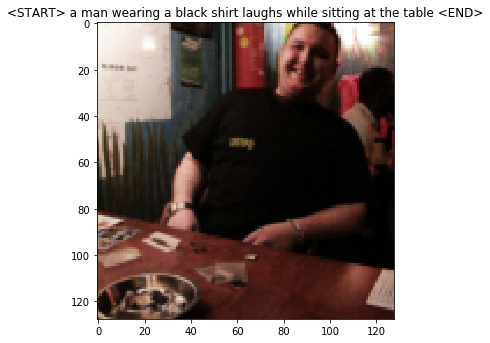

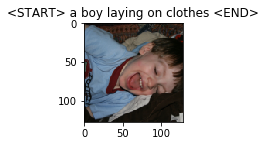

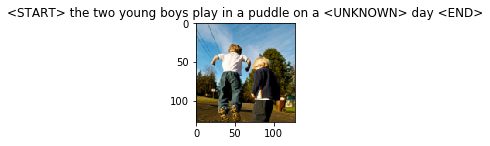

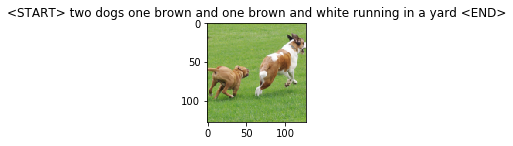

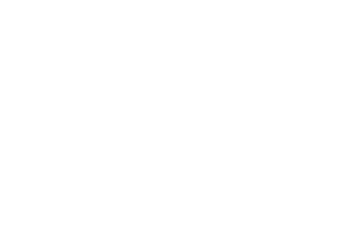

In [19]:
# Plot some examples from the training set
from matplotlib import pyplot as plt

nrows = 2
ncols = 2
plt.figure(figsize=(16, 12))
for i in range(nrows * ncols):
    idx = random.randint(0, len(ds_train)-1)
    im, caption, *_ = ds_train[idx]
    plt.subplot(nrows, ncols, i+1)
    plt.title(ds_train.lang.decode_caption(caption))
    imshow(im)
    plt.axis('off')

In [20]:
# plot the distribution of captions lengths
#caption_lengths = [smpl[2] for smpl in ds_train]  # this takes a while
# plt.hist(caption_lengths)
# plt.title(f'caption lengths, mean = {np.mean(caption_lengths):.1f}')
# plt.xlabel('caption length')
# plt.ylabel('frequency')
# plt.show()

In [21]:
# evalloader = DataLoader(ds_eval, batch_size, shuffle=False, 
#                          num_workers=num_workers, pin_memory=True,
#                          collate_fn=collate_fn)

In [22]:
# it = iter(evalloader)
# batch = next(it)

In [32]:
# idx = 15
# imshow(batch[0][idx])
# print(ds_train.decode_caption(batch[2][idx]))

### Model initialization and training

In [54]:
# hyperparameters
num_hidden = 512
embedding_dim = 512
batch_size = 64
epochs = 20
num_workers = 0
num_layers = 2

In [55]:
from src.models import EncoderDecoder, LSTMDecoder, ResNetEncoder

encoder = ResNetEncoder(num_hidden)
decoder = LSTMDecoder(num_hidden, embedding_dim, vocab_size, encoder.annotation_dim, lang.word2idx['<START>'], device, num_layers=num_layers)
encoder, decoder = encoder.to(device), decoder.to(device)

model = EncoderDecoder(encoder, decoder, device)
model = model.to(device);

08/04/2021 01:26:06 - src.models - INFO - Number of trainable parameters: 49600168


In [56]:
#device

In [57]:
model

EncoderDecoder(
  (encoder): ResNetEncoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True

In [58]:
optimizer = optim.Adam(model.parameters(), lr = 4e-4, weight_decay = 1e-3)
# optimizer = optim.RMSprop(model.parameters(), 0.01)
# optimizer = optim.SGD(model.parameters(), 0.001, momentum=0.9)

In [59]:
# overfit on a mini dataset
ds_train_mini = torch.utils.data.Subset(ds_train, [random.randint(0, len(ds_train) - 1) for _ in range(3)])
ds_eval_mini = torch.utils.data.Subset(ds_eval, [0, 1])

In [60]:
from src.trainer import Trainer, TrainerConfig
from src.utils import train_collate_fn, eval_collate_fn, make_predictions
from src.metrics import calculate_bleu_score
from functools import partial

config = TrainerConfig(batch_size=batch_size, epochs=epochs, 
                       num_workers=num_workers, track_grad_norm=False,
                       track_loss=True, track_accuracy=False)
#trainer = Trainer(config, model, optimizer, ds_train_mini, train_collate_fn=train_collate_fn, eval_collate_fn=eval_collate_fn,
#                   evaluation_callback_fn=partial(make_predictions, n_predictions=2),
                  # metrics_callback_fn=partial(calculate_bleu_score, lang=lang))
# trainer = Trainer(config, model, optimizer, ds_train, ds_eval, train_collate_fn,
#                   eval_collate_fn, evaluation_callback_fn=partial(make_predictions, n_predictions=4),
#                   metrics_callback_fn=partial(calculate_bleu_score, lang=lang))
trainer = Trainer(config, model, optimizer, ds_train, ds_eval, train_collate_fn,  # no intermediate predictions
                   eval_collate_fn, metrics_callback_fn=partial(calculate_bleu_score, lang=lang))

In [61]:
trainer.train()

100%|██████████| 94/94 [01:10<00:00,  1.33it/s]
08/04/2021 01:27:17 - src.trainer - INFO - epoch 0 - train_loss: 4.9820
08/04/2021 01:27:26 - src.trainer - INFO - BLEU-1: 20.7
08/04/2021 01:27:26 - src.trainer - INFO - BLEU-2: 10.2
08/04/2021 01:27:26 - src.trainer - INFO - BLEU-3: 3.2
08/04/2021 01:27:26 - src.trainer - INFO - BLEU-4: 1.4
08/04/2021 01:27:26 - src.trainer - INFO - New best score: 10.231062. Saving checkpoint.
100%|██████████| 94/94 [01:12<00:00,  1.30it/s]
08/04/2021 01:28:39 - src.trainer - INFO - epoch 1 - train_loss: 3.8386
08/04/2021 01:28:49 - src.trainer - INFO - BLEU-1: 19.9
08/04/2021 01:28:49 - src.trainer - INFO - BLEU-2: 10.0
08/04/2021 01:28:49 - src.trainer - INFO - BLEU-3: 3.4
08/04/2021 01:28:49 - src.trainer - INFO - BLEU-4: 1.3
100%|██████████| 94/94 [01:11<00:00,  1.32it/s]
08/04/2021 01:30:00 - src.trainer - INFO - epoch 2 - train_loss: 3.5223
08/04/2021 01:30:10 - src.trainer - INFO - BLEU-1: 20.0
08/04/2021 01:30:10 - src.trainer - INFO - BLEU-2: 

KeyboardInterrupt: 